# Ensemble Learning

## Imports and Setting up the Kaggle API
### Create .env File and Set KAGGLE_KEY and KAGGLE_USERNAME as Kaggle Username and Key in .env File
### Example:
KAGGLE_KEY=API_KEY
KAGGLE_USERNAME=USERNAME

load_dotenv will take .env and set key pairs as environmental variables in Python

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
import kaggle
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
import copy



Setting the API Instance and downloading dataset

In [3]:
apiInstance=kaggle.KaggleApi()
apiInstance.dataset_download_files('fedesoriano/stroke-prediction-dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


## Preprocessing
Prior to model training, a comprehensive preprocessing pipeline was implemented to ensure data quality, prevent information leakage, and prepare the dataset for use with a boosted tree model (XGBoost). Preprocessing decisions were made with careful consideration of the dataset’s mixed data types, missing values, and significant class imbalance.


In [4]:
strokeData=pd.read_csv('healthcare-dataset-stroke-data.csv')
strokeDataFeatures=strokeData.iloc[:,1:-1]
#iloc[rows,columns] we used : on rows as : specifies a range so a range with no upper or lower bound means taking everyting
#1:-1 means a range from 1(dropping our first column) to -1(which really means our last column)
#dropping the first column our ID column since it has no predictive power and can potentially cause any learners we use to develop patterns on it
#dropping the last column since we only want our features and not the labels
strokeDataLabels=strokeData.iloc[:,-1]
#getting only the last column as we only want the labels

### Train-Test Split
The dataset was first divided into training and test sets using a stratified split to preserve the original class distribution of the stroke outcome variable.

- Training set: 80%
- Test set: 20%
- Stratification applied on the target label to maintain class balance

This split was performed before any preprocessing steps to avoid data leakage from the test set into the training process.

In [5]:
from sklearn.model_selection import train_test_split
trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(
    strokeDataFeatures, strokeDataLabels, test_size=0.2, random_state=42,stratify=strokeDataLabels)
#splitting the dataset into test and train data
#we want to split before we do any other preprocessing as we don't want our train feature preprocessing learning information from our test features

### Imputation and Encoding
To prepare the dataset for training with a boosted tree model, imputation and feature encoding were performed as part of a unified preprocessing step. These procedures were designed to handle missing values, convert categorical variables into numerical representations, and ensure consistency between the training and test datasets while avoiding information leakage.


In [6]:
print(trainFeatures.info())

print("\n Train Data Labels vs Presence of Nans in Label Column \n")
print(f"{trainFeatures.isnull().any()}\n")

print("\n Test Data Labels vs Presence of Nans in Label Column \n")
print(f"{testFeatures.isnull().any()}\n")
#BMI is the only column with NaNs

<class 'pandas.core.frame.DataFrame'>
Index: 4088 entries, 845 to 5052
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                3918 non-null   float64
 9   smoking_status     4088 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 351.3+ KB
None

 Train Data Labels vs Presence of Nans in Label Column 

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_

### Missing Value Imputation

The dataset contained missing values in the BMI feature. To address this, a median-based imputation strategy was applied.

The imputer was fit exclusively on the training data to learn the median BMI value. This learned value was then used to transform both the training and test datasets. Median imputation was selected because it is robust to outliers and well suited for skewed distributions, particularly in imbalanced medical datasets.

### Categorical Feature Identification and Encoding

Categorical features were analyzed based on their data type and number of unique categories.

Features with more than two unique categorical values were encoded using one-hot encoding. This approach ensures that no artificial ordinal relationships are introduced between categories and allows each category to be represented independently.

Binary categorical features were encoded using ordinal encoding, mapping each category directly to a numerical value. This representation is appropriate for binary variables and avoids unnecessary expansion of the feature space.

To ensure robustness during transformation of the test set, the one-hot encoder was configured to ignore unseen categories that may appear in new data.

### Numerical Feature Scaling

Continuous numerical features were standardized using z-score normalization. These features included age, average glucose level, and BMI. Binary numerical features were excluded from scaling, as their values already lie on a consistent scale.

The scaling parameters were learned from the training data and then applied to the test data to prevent information leakage.

### Column Transformation Pipeline

All preprocessing steps were applied using a column transformation framework, which allowed different transformations to be applied in parallel to specific feature subsets. Ordinal encoding, one-hot encoding, and feature scaling were applied to their respective columns, while all remaining features were passed through unchanged.

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer



#we want to use standard scaler to scale the inputs for the numberical inputs to avoid problems with weights for different model types
#standard scaler or minmax scaler are good but we will use StandardScaler
#we want to use onehotencoder for categorical columns
# that have more than 2 possible awnsers, ordinal or label encoder for categorical columsn that have only 2 possible awnsers and then we want to use the columnTransformer to apply these encoders to the columsn we want to apply them to
#these lines help us figure out which columsn need to be onehotencoded and which need to be converted to binary

trainFeaturesToIterate=copy.copy(trainFeatures)
columnsToOneHotEncode=[]
print('\nColumns to be OneHotEncoded: \n')
for column in trainFeaturesToIterate:
    if (trainFeatures[column].nunique()>2) & (trainFeatures[column].dtype == 'object'):
        columnsToOneHotEncode.append(column)
        print(f'{column} has unique categories of {trainFeatures[column].unique()}')
        trainFeaturesToIterate.drop(column, axis=1, inplace=True)
#gender work_type and smoking_status should be OneHotEncoded to avoid the learners accidentally ranking
columnsToOrdinalEncoded=[]
print('\nColumns to be converted to Binary \n')
for column in trainFeaturesToIterate:
    if (trainFeatures[column].nunique()==2) & (trainFeatures[column].dtype == 'object'):
        columnsToOrdinalEncoded.append(column)
        print(f'{column} has unique categories of {trainFeatures[column].unique()}')
        trainFeaturesToIterate.drop(column, axis=1, inplace=True)
#ever_married and residence_type can be converted to binary 0 and 1 since there are only 2 values


columnsToScale=[]
print('\nColumns to be scaled \n')
for column in trainFeaturesToIterate:
    if trainFeatures[column].dtype in ['float64', 'int64']:
        uniqueVals = set(trainFeatures[column].unique())
        if uniqueVals != {0, 1}:
            columnsToScale.append(column)
            print(f'{column} is a numerical category that must be scaled')
            trainFeaturesToIterate.drop(column, axis=1, inplace=True)
#age,avg_glucose_level and bmi are our numerical data values which needs to be scalled down

#column transformer takes in an array of tuples(each tuples has three values) each tuple is represents an encoder you will use on some columns in the tuples you have three values the first value is some arbitrary name like 'ordinalEncoder' and the second vlaue is the function for the encoder itself like OrdinalEncoder() the third value is a list of the column indices or column names if the data is a dataframe which you want that specific encoder to be used on so in this case we only want our OrdinalEncoder to

#columnTransformers runs each transformer in parallel and we want to impute values before we scale them so we want to create a pipeline for our numberical non discrete columns i.e. the columns that need to be scaled

#before we do aanything we need to impute the missing values that are present in bmi in both the trainFeatures and the testFeatures
imputer = SimpleImputer(strategy="median")
imputer.fit(trainFeatures[["bmi"]])
trainFeatures["bmi"] = imputer.transform(trainFeatures[["bmi"]])
testFeatures["bmi"]  = imputer.transform(testFeatures[["bmi"]])

ct=ColumnTransformer(transformers=[('ordinalEncoder', OrdinalEncoder(), columnsToOrdinalEncoded),('oneHotEncoder', OneHotEncoder(handle_unknown="ignore"), columnsToOneHotEncode),('scaler', StandardScaler(),columnsToScale)],remainder='passthrough')
del trainFeaturesToIterate
trainFeatures=ct.fit_transform(trainFeatures)
testFeatures=ct.transform(testFeatures)
print(ct.get_feature_names_out())
print(pd.DataFrame(trainFeatures).info())
print(pd.DataFrame(testFeatures).info())


Columns to be OneHotEncoded: 

gender has unique categories of ['Female' 'Male' 'Other']
work_type has unique categories of ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
smoking_status has unique categories of ['never smoked' 'smokes' 'Unknown' 'formerly smoked']

Columns to be converted to Binary 

ever_married has unique categories of ['Yes' 'No']
Residence_type has unique categories of ['Urban' 'Rural']

Columns to be scaled 

age is a numerical category that must be scaled
avg_glucose_level is a numerical category that must be scaled
bmi is a numerical category that must be scaled
['ordinalEncoder__ever_married' 'ordinalEncoder__Residence_type'
 'oneHotEncoder__gender_Female' 'oneHotEncoder__gender_Male'
 'oneHotEncoder__gender_Other' 'oneHotEncoder__work_type_Govt_job'
 'oneHotEncoder__work_type_Never_worked'
 'oneHotEncoder__work_type_Private'
 'oneHotEncoder__work_type_Self-employed'
 'oneHotEncoder__work_type_children'
 'oneHotEncoder__smoking_status_Unknown

In [8]:
print(trainFeatures[0])
print(trainLabels[0])

[ 1.          1.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  1.          0.          0.20566087 -0.8199733   0.543113    0.
  0.        ]
1


# Model Creation, Setup and Analytical Measurement


## XGBoost Testing
To establish a baseline understanding of XGBoost behavior on the stroke prediction dataset, an initial model was trained using default-style hyperparameters and the root mean squared error (RMSE) evaluation metric. Training and evaluation performance were monitored across boosting iterations using both the training and test datasets.

During this initial testing phase, the model exhibited clear signs of overfitting. As the number of boosting rounds increased, the training error steadily decreased while the evaluation error increased. This divergence indicates that the model was increasingly fitting noise in the training data rather than learning generalizable patterns

In addition to overfitting concerns, RMSE was found to be an unsuitable evaluation metric for this task. Stroke prediction is a binary classification problem with a highly imbalanced class distribution, where the minority class represents stroke occurrences. RMSE does not explicitly account for class imbalance and does not differentiate between false positives and false negatives. As a result, a model optimized for RMSE may achieve low error by primarily predicting the majority class, while failing to correctly identify stroke cases.

Because false negatives are particularly costly in medical screening contexts, evaluation metrics that emphasize sensitivity to the positive class are more appropriate. This observation motivated a transition away from RMSE toward a classification-focused metric that better reflects model performance on the minority class.

Based on these findings, subsequent experiments replaced RMSE with the area under the precision–recall curve (PR-AUC) as the primary evaluation metric. PR-AUC provides a more informative assessment of performance for imbalanced classification tasks by directly capturing the trade-off between precision and recall, particularly for rare positive outcomes such as strokes.

In [9]:
dTrain=xgb.DMatrix(trainFeatures, trainLabels)
dTest = xgb.DMatrix(testFeatures, testLabels)
#xgboost parameters we will need to optimize to make ours ensemble training better

#Tree Booster Parameters

#eta is our learning rate
#gamma is the minimum loss reduction to make a further leaf partition increasing makes the model less complex
#max_depth is max depth of the tree increasing max depth can make the model more complex
#min_child_weight relates to the minimum amount of samples can be in a leaf node increasing decrease the model complexity
#max_delta_step acts to reduce how fast leaf values can change important for us as the skewed dataset can mean that the tree can change drastically to fit our very low amount of strokes in dataset so by increasing max_delta_step above 0 we can reduce the rate of change of leaf values meaning there is a less change of our skewed dataset from overfitting quickly
#subsample tells how much of the dataset to randomly sample before growin tree decreasing number will help reduce overfitting
#sampling_method how the dataset samples are chosen uniform means each instance has an equal change of being chosen and gradient based samples are chosen based on which samples have the greatest gradient, most variation between predicted label and actual label
#colsample_bylevel,colsample_bytree,colsample_bynode control the amount of features(columns) can be used at each by object so colsample_bylevel=0.5 means that only 50% of the available features can be used to split at the level decreasing features used can reduce overfitting by forcing the tree to use different features
#lambda alpha are L1,L2 regularization terms respectively increasing them increases how conservative the model is
#tree_method controls tree construction algorithm exact approx hist
#scale_pos_weight controls the balance of positive and negative weights
#updater A comma separated string defining the sequence of tree updaters to run, providing a modular way to construct and to modify the trees.
#process_type type of boosting process to run we don't need to change for us
#grow_policy controls how new nodes are added to the tree
#max_leaves controls maxiumum number of nodes to add


#Learning Task Parameters

#objective controls which objective function we use
#base_score controls initial prediction of all instances
#eval_metric evaluation metrics for validation data
#seed random number seed


params = {'objective':'binary:logistic','eval_metric':'rmse','eta':0.3,'gamma':0,'max_depth':6,'min_child_weight':1,'max_delta_step':0,'subsample':1,'sampling_method':'uniform','colsample_bylevel':1,'colsample_bytree':1,'colsample_bynode':1,'alpha':0,'lambda':1,'tree_method':'auto','scale_pos_weight':1,'refresh_leaf':1,'process_type':'default','grow_policy':'depthwise','max_leaves':0,'max_bin':256,}

evalList = [(dTrain, 'train'), (dTest, 'eval')]

"""params (Dict[str, Any]) – Booster params.

dtrain (DMatrix) – Data to be trained.

num_boost_round (int) – Number of boosting iterations.

evals (Sequence[Tuple[DMatrix, str]] | None) – List of validation sets for which metrics will evaluated during training. Validation metrics will help us track the performance of the model."""

bst=xgb.train(params=params, dtrain=dTrain, num_boost_round=100, evals=evalList, verbose_eval=True)



[0]	train-rmse:0.20464	eval-rmse:0.20994
[1]	train-rmse:0.19721	eval-rmse:0.20856
[2]	train-rmse:0.19265	eval-rmse:0.20738
[3]	train-rmse:0.18952	eval-rmse:0.20752
[4]	train-rmse:0.18695	eval-rmse:0.20711
[5]	train-rmse:0.18448	eval-rmse:0.20630
[6]	train-rmse:0.18127	eval-rmse:0.20668
[7]	train-rmse:0.17991	eval-rmse:0.20652
[8]	train-rmse:0.17783	eval-rmse:0.20647
[9]	train-rmse:0.17699	eval-rmse:0.20659
[10]	train-rmse:0.17572	eval-rmse:0.20706
[11]	train-rmse:0.17315	eval-rmse:0.20746
[12]	train-rmse:0.17271	eval-rmse:0.20709
[13]	train-rmse:0.17230	eval-rmse:0.20718
[14]	train-rmse:0.17142	eval-rmse:0.20731
[15]	train-rmse:0.17073	eval-rmse:0.20733
[16]	train-rmse:0.17028	eval-rmse:0.20737
[17]	train-rmse:0.16938	eval-rmse:0.20750
[18]	train-rmse:0.16787	eval-rmse:0.20777
[19]	train-rmse:0.16675	eval-rmse:0.20834
[20]	train-rmse:0.16541	eval-rmse:0.20876
[21]	train-rmse:0.16435	eval-rmse:0.20845
[22]	train-rmse:0.16227	eval-rmse:0.20919
[23]	train-rmse:0.16027	eval-rmse:0.20933
[2

Clear overfitting occurring as our train rmse goes down but our eval rmse goes up.

In [10]:
params['eval_metric']='aucpr'
#auc is a good metric for classification which is the problem we are trying to solve and it is sensitive to false negatives i.e. missing a stroke which we do not want occuring
bst1=xgb.train(params=params, dtrain=dTrain, num_boost_round=100, evals=evalList, verbose_eval=True)

[0]	train-aucpr:0.28578	eval-aucpr:0.20355
[1]	train-aucpr:0.40758	eval-aucpr:0.18801
[2]	train-aucpr:0.44578	eval-aucpr:0.19553
[3]	train-aucpr:0.46944	eval-aucpr:0.19111
[4]	train-aucpr:0.49687	eval-aucpr:0.20160
[5]	train-aucpr:0.52073	eval-aucpr:0.22373
[6]	train-aucpr:0.55634	eval-aucpr:0.21643
[7]	train-aucpr:0.57205	eval-aucpr:0.21640
[8]	train-aucpr:0.59467	eval-aucpr:0.22401
[9]	train-aucpr:0.60335	eval-aucpr:0.21595
[10]	train-aucpr:0.61445	eval-aucpr:0.21053
[11]	train-aucpr:0.63836	eval-aucpr:0.20160
[12]	train-aucpr:0.64307	eval-aucpr:0.20710
[13]	train-aucpr:0.64541	eval-aucpr:0.20583
[14]	train-aucpr:0.65381	eval-aucpr:0.20348
[15]	train-aucpr:0.66102	eval-aucpr:0.20541
[16]	train-aucpr:0.66666	eval-aucpr:0.20442
[17]	train-aucpr:0.67090	eval-aucpr:0.20488
[18]	train-aucpr:0.68740	eval-aucpr:0.20506
[19]	train-aucpr:0.69941	eval-aucpr:0.20039
[20]	train-aucpr:0.71265	eval-aucpr:0.19849
[21]	train-aucpr:0.72171	eval-aucpr:0.19972
[22]	train-aucpr:0.73568	eval-aucpr:0.1944

## Defining Metrics

### Defining Computational and Environmental Metrics for XGBoost

To evaluate the computational efficiency and environmental impact of the boosted tree model (XGBoost), a set of model-appropriate metrics was defined and implemented directly within the training and tuning workflow. While many efficiency and sustainability metrics apply broadly across machine learning models, neural-network-specific measures require adaptation when applied to tree-based algorithms. To enable meaningful comparison with neural network approaches, floating point operations (FLOPs) were explicitly estimated for boosted decision trees using a traversal-based approximation that reflects the structure of tree ensembles.

All metrics were collected programmatically during execution using a custom monitoring utility. As a result, the reported values reflect the full cost of model development, including cross-validated grid search, learning rate tuning with early stopping, and final model training, rather than only the cost of the final fitted model.

### Computational Metrics

The following metrics were used to quantify computational efficiency for the boosted tree model:

- Training time
- Average CPU utilization
- Peak CPU utilization
- RAM usage
- Floating point operations (FLOPs)

### Computational Metric Definitions

Training time (s)
= End time − Start time

Training time was measured as wall-clock time spanning the entire model development process, including hyperparameter search and final training.

Average CPU utilization (%)
= (Sum of CPU utilization samples) / (Number of samples)

CPU usage was sampled periodically during execution using system-level monitoring, capturing average utilization across the full training and tuning period.

Peak CPU utilization (%)
= Maximum value observed across all CPU samples

Peak CPU utilization represents the highest instantaneous CPU usage observed during model training or evaluation.

RAM usage (GB)
= Resident Set Size (bytes) / 1,000,000,000

Memory usage was measured using the process resident set size, capturing the total memory footprint of the Python process, including the dataset stored in XGBoost’s DMatrix format and the learned tree structures.

### FLOPs Estimation for Boosted Trees

Boosted trees do not rely on dense matrix multiplications as neural networks do. Instead, their computational cost is dominated by decision node evaluations during tree traversal and gradient-based updates during training. FLOPs were therefore estimated using a traversal-based approximation aligned with the structure of boosted decision trees.

FLOPs per training run
= Number of samples × Number of boosting rounds × Average tree depth × k × C

where:

- Average tree depth serves as a proxy for the number of node evaluations per tree
- k represents the number of floating point operations per node evaluation, accounting for comparison and branching
- C is a training multiplier accounting for forward traversal, gradient computation, and tree update operations

### Cumulative FLOPs Accounting

To accurately capture total computational cost, FLOPs were accumulated across all stages of model development.

Grid search FLOPs were estimated by multiplying the FLOPs of a single model by the number of hyperparameter combinations and the number of cross-validation folds.

Learning rate and early stopping FLOPs were added based on the actual number of boosting rounds executed before early stopping for each configuration.

Final model FLOPs were computed separately using the same formulation, allowing the cost of the selected model to be reported independently while still retaining the cumulative FLOPs from tuning.

This approach ensures that the reported FLOPs represent the full computational expense of model selection rather than underestimating cost by considering only the final model.

### Environmental Metrics

The following metrics were used to estimate the environmental impact of training the boosted tree model:

- Energy consumption
- CO2 emissions
- Water consumption

### Environmental Metric Formulas

Energy consumption (Wh)
= (Average power usage × Training time) / 3600

Training was performed on a personal computing device using CPU-based execution. A constant average power draw of 3.6 W was assumed based on system-level measurements.

CO2 emissions (g)
= Energy consumption × Carbon intensity

Carbon intensity was assumed to be 0.408 gCO2/Wh, corresponding to the regional electricity grid average.

Water consumption (mL)
= Energy consumption × Water intensity

A water intensity of 2.18 L/kWh (2.18 mL/Wh) was used based on U.S. national averages.

### Notes on Environmental Assumptions

Training was performed on a personal laptop rather than in a data center environment, so power usage effectiveness was not included. Region-specific carbon and water intensity data were unavailable, and national averages were applied. Cooling and infrastructure overhead factors were omitted for simplicity.



In [11]:
import time, psutil, os, threading
import numpy as np

class TreeMetrics:
    def __init__(self, name="XGBoost", carbonIntensity=0.408, waterIntensity=2.18):
        self.name = name
        self.carbonIntensity = carbonIntensity
        self.waterIntensity = waterIntensity
        self.process = psutil.Process(os.getpid())
        self.cpuSamples = []
        self.totalFlops = 0

    # Runtime monitoring
    def start(self):
        self.startTime = time.time()
        self.cpuSamples = []
        self.monitoring = True
        self.monitor_thread = threading.Thread(
            target=self._monitor_cpu, daemon=True
        )
        self.monitor_thread.start()
        print(f"Tracking: {self.name}")

    def _monitor_cpu(self):
        while self.monitoring:
            self.cpuSamples.append(psutil.cpu_percent(interval=0.1))
            time.sleep(0.5)

    def stop(self):
        self.endTime = time.time()
        self.monitoring = False
        if hasattr(self, "monitor_thread"):
            self.monitor_thread.join(timeout=2.0)

    # FLOPs accounting
    """FLOPs for XGBoost training:num_samples × num_trees × depth × node_ops × train_ops"""
    def addFlopsTraining(
        self,numSamples,numBoostRounds,avgTreeDepth,kNode=4,cTrain=3):
        flops = (
            numSamples *
            numBoostRounds *
            avgTreeDepth *
            kNode *
            cTrain
        )
        self.totalFlops += flops

    def addFlopsGridsearch(
        self,paramGrid,numEstimators,cv,numSamples,kNode=4,cTrain=3):
        numParamCombos = 1
        for v in paramGrid.values():
            numParamCombos *= len(v)

        avgDepth = np.mean(paramGrid["max_depth"])

        flopsPerModel = (
            numSamples *
            numEstimators *
            avgDepth *
            kNode *
            cTrain
        )

        total = flopsPerModel * numParamCombos * cv
        self.totalFlops += total
        """Computes FLOPs for training the final selected XGBoost model only.
        kNode : intFLOPs per node evaluation (comparison + branching)
        CTrain :Training multiplier (forward + gradient + update)"""
    def computeFinalModelFlops(
        self,numSamples,numBoostRounds,avgTreeDepth,kNode=4,cTrain=3):

        flops = (
            numSamples *
            numBoostRounds *
            avgTreeDepth *
            kNode *
            cTrain
        )

        return flops
    # Final report
    def report(self, powerUsage=3.6):
        trainingTime = self.endTime - self.startTime

        avgCpu = (
            sum(self.cpuSamples) / len(self.cpuSamples)
            if self.cpuSamples else 0
        )
        peak_cpu = max(self.cpuSamples) if self.cpuSamples else 0

        energy = powerUsage * trainingTime / 3600
        co2 = energy * self.carbonIntensity
        water = energy * self.waterIntensity

        print("\n===== FINAL COMPUTE REPORT =====")
        print(f"Training time: {trainingTime:.2f}s ({trainingTime/60:.2f} min)")
        print(f"Average CPU Utilization: {avgCpu:.2f}%")
        print(f"Peak CPU Utilization: {peak_cpu:.2f}%")
        print(f"RAM Usage: {self.process.memory_info().rss/1e9:.2f} GB")
        print(f"Total Estimated FLOPs: {self.totalFlops/1e9:.3f} GFLOPs")
        print(f"Energy Consumption: {energy:.6f} Wh")
        print(f"CO₂ Emissions: {co2:.6f} g")
        print(f"Water Consumption: {water:.4f} mL")


## Model Creation and Tuning


### Cross-Validated Hyperparameter Optimization

This section performs structured hyperparameter tuning using cross-validated grid search to identify robust tree-level and regularization settings for the XGBoost model.

Before model tuning begins, computational tracking is initialized using the TreeMetrics utility. This enables measurement of training time, CPU utilization, and cumulative FLOPs across all tuning stages, ensuring that the full cost of model selection is accounted for rather than only the final model fit.

Class imbalance is explicitly handled prior to training by computing the ratio of negative to positive samples in the training set. This ratio is used to set the scale_pos_weight parameter, which increases the penalty for misclassifying stroke cases and encourages the model to allocate more capacity to the minority class without altering the underlying data distribution.

An XGBoost classifier is then instantiated using conservative baseline settings. The exact tree construction method is selected due to the moderate dataset size, allowing precise split evaluation. Subsampling and column sampling are fixed below one to reduce variance and mitigate overfitting, while the evaluation metric is set to PR-AUC to align with the imbalanced classification objective.

Hyperparameter tuning is conducted using GridSearchCV with five-fold cross-validation. The parameter grid focuses on tree depth, minimum child weight, loss reduction threshold, and L1 and L2 regularization strengths. These parameters directly control model complexity and generalization behavior, making them appropriate candidates for structured search. Average precision is used as the scoring metric to remain consistent with the PR-AUC optimization goal.

After fitting the grid search, the total computational cost of this stage is estimated by explicitly adding FLOPs associated with all cross-validated model fits. This calculation accounts for the number of parameter combinations, the number of cross-validation folds, the number of estimators per model, and the training set size. By incorporating grid search FLOPs into the overall accounting, the reported compute metrics accurately reflect the full cost of model selection rather than only the final chosen configuration.


In [12]:
from sklearn.model_selection import GridSearchCV

metrics = TreeMetrics(name="XGBoost Final Model")
metrics.start()
"""scale_pos_weights Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)"""
neg = (trainLabels == 0).sum()
pos = (trainLabels == 1).sum()

scale_pos_weight = neg / pos
print(scale_pos_weight)

bstSklearnWrapper=xgb.XGBClassifier(n_estimators=100, max_depth=6,tree_method='exact',learning_rate=0.1,objective="binary:logistic", booster='gbtree',gamma=0,min_child_weight=3,max_delta_step=1,subsample=0.7,colsample_bytree=0.7,colsample_bylevel=1,colsample_bynode=1,reg_alpha=0,reg_lambda=1,scale_pos_weight=scale_pos_weight,random_state=42,eval_metric='aucpr')
paramGrid={'max_depth':[3,4,5,6],'max_delta_step':[1,2,3,4],'min_child_weight':[2,3,4],'gamma':[0,1],'reg_alpha':[0,1],"reg_lambda":[0,1]}
grid=GridSearchCV(estimator=bstSklearnWrapper,param_grid=paramGrid,cv=5,scoring='average_precision',verbose=1)
grid.fit(trainFeatures, trainLabels)
metrics.addFlopsGridsearch(
    paramGrid=paramGrid,
    numEstimators=bstSklearnWrapper.n_estimators,
    cv=grid.cv,
    numSamples=trainFeatures.shape[0]
)



Tracking: XGBoost Final Model
19.542713567839197
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


### Extracting the Best Grid Search Configuration

After completing cross-validated hyperparameter tuning, the best-performing model configuration is extracted from the grid search. The best estimator represents the combination of tree structure and regularization parameters that achieved the highest average precision across validation folds. The corresponding parameter values and cross-validation score are printed to document the selected configuration and its performance.

The full parameter dictionary of the selected estimator is then retrieved. From this dictionary, a streamlined set of core training parameters is constructed. This base parameter set includes the objective function, evaluation metric, tree construction method, depth and regularization settings, sampling behavior, class imbalance weighting, and random seed. Learning rate and number of boosting rounds are intentionally excluded at this stage, as these parameters are tuned separately due to their strong interaction.

This separation allows the structural complexity of the model to be fixed before optimizing training dynamics.

In [13]:
bestModel=grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)
skParams = grid.best_estimator_.get_params()
baseParams = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "tree_method": skParams["tree_method"],
    "booster": skParams["booster"],
    "max_depth": skParams["max_depth"],
    "min_child_weight": skParams["min_child_weight"],
    "max_delta_step": skParams["max_delta_step"],
    "subsample": skParams["subsample"],
    "colsample_bytree": skParams["colsample_bytree"],
    "gamma": skParams["gamma"],
    "alpha": skParams["reg_alpha"],
    "lambda": skParams["reg_lambda"],
    "scale_pos_weight": skParams["scale_pos_weight"],
    "seed": skParams["random_state"],
}
print(baseParams)



{'gamma': 0, 'max_delta_step': 3, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 0}
0.23254648276381293
{'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'tree_method': 'exact', 'booster': 'gbtree', 'max_depth': 5, 'min_child_weight': 3, 'max_delta_step': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0, 'alpha': 1, 'lambda': 0, 'scale_pos_weight': np.float64(19.542713567839197), 'seed': 42}


### Validation Split for Learning Rate and Boosting Round Search

To tune the learning rate and number of estimators, the training data is further split into a reduced training subset and a held-out validation subset. Stratification is applied to preserve the original class imbalance, ensuring that stroke cases remain adequately represented during evaluation.

Both subsets are converted into XGBoost DMatrix objects, which provide optimized memory handling and efficient computation during training.

In [14]:
#splitting the train data into train data and validation data
trainFeatures, valFeatures, trainLabels, valLabels = train_test_split(
    trainFeatures, trainLabels, test_size=0.2, random_state=42,stratify=trainLabels)
dVal = xgb.DMatrix(valFeatures, valLabels)
dTrain = xgb.DMatrix(trainFeatures, trainLabels)

### Joint Optimization of Learning Rate and Early Stopping

Learning rate and number of estimators are optimized jointly using a nested loop over candidate learning rates and early stopping patience values. For each combination, the model is trained using a large upper bound on the number of boosting rounds, while early stopping halts training once validation performance stops improving.

This approach allows the effective number of trees to be determined dynamically rather than fixed in advance, preventing unnecessary training and reducing overfitting risk.

For each trained model, computational cost is explicitly tracked by adding estimated FLOPs based on the number of samples, the number of trees actually trained before early stopping, and the fixed tree depth. This ensures that the total computational footprint of the learning rate search is included in the final metrics.

Validation predictions are generated for each model, and PR-AUC is computed on the validation set. Each result, including the learning rate, early stopping patience, effective number of estimators, validation PR-AUC, and trained model, is stored for comparison.

Once all learning rate and early stopping combinations have been evaluated, the model achieving the highest validation PR-AUC is selected as the final model. This selection criterion prioritizes performance on the minority stroke class and aligns with the overall objective of minimizing false negatives.

The final parameter set is assembled by combining the previously fixed base parameters with the selected learning rate. This configuration is used for final evaluation on the test set and for reporting computational and environmental metrics.

In [15]:
import xgboost as xgb
from sklearn.metrics import average_precision_score
learningRates = [0.001,0.003,0.005,0.008,0.01, 0.03, 0.05, 0.08, 0.1,0.3]
earlyStoppingRounds = [20,30,40,50,60,70,80,100]

results = []
for learningRate in learningRates:
    for patience in earlyStoppingRounds:
        params = baseParams.copy()
        params['learning_rate'] = learningRate

        booster = xgb.train(
            params=params,
            dtrain=dTrain,
            num_boost_round=2000,
            evals=[(dVal, "val")],
            early_stopping_rounds=patience,
            verbose_eval=False
        )
        metrics.addFlopsTraining(
            numSamples=dTrain.num_row(),
            numBoostRounds=booster.best_iteration + 1,
            avgTreeDepth=baseParams["max_depth"]
        )

        yValProba = booster.predict(dVal)
        pr_auc = average_precision_score(valLabels, yValProba)

        results.append({
            "learningRate": learningRate,
            "earlyStoppingRounds": patience,
            "bestNumEstimators": booster.best_iteration + 1,
            "valPrAuc": pr_auc,
            "model": booster
        })
bestResult = max(results, key=lambda x: x["valPrAuc"])
print(bestResult)
bestModel=bestResult["model"]
bestParamsFinal = baseParams.copy()
bestParamsFinal["learning_rate"] = bestResult["learningRate"]

{'learningRate': 0.008, 'earlyStoppingRounds': 50, 'bestNumEstimators': 26, 'valPrAuc': 0.18387008596980342, 'model': <xgboost.core.Booster object at 0x141959c20>}


### Decision Threshold Optimization

After selecting the best-performing boosted tree model, the final tuning step focuses on optimizing the decision threshold used to convert predicted probabilities into binary class labels. By default, probabilistic classifiers use a threshold of 0.5; however, in highly imbalanced medical datasets, this default choice often leads to an unacceptable number of false negatives.

The trained model is first used to generate predicted probabilities for the validation set. Rather than committing to a single threshold, a range of candidate thresholds between 0.01 and 0.99 is evaluated. For each threshold, predicted probabilities are converted into class labels, and precision, recall, and F1-score are computed.

These metrics are recorded for each threshold to characterize the trade-off between correctly identifying stroke cases and minimizing false alarms. Because missed stroke predictions are particularly costly, recall is treated as a primary constraint. Only thresholds that achieve a recall of at least 0.85 on the validation set are considered viable.

Among this filtered set of thresholds, the threshold that maximizes precision is selected. This approach ensures that the final classifier maintains high sensitivity to stroke cases while improving precision as much as possible under the recall constraint.

Once the optimal threshold is identified, model training and tuning are complete, and computational monitoring is stopped. The selected threshold is then used for final evaluation on the held-out test set.

In [16]:
yValProba = bestModel.predict(dVal)

from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.01, 0.99, 99)
thresholdResults = []

for t in thresholds:
    yValPred = (yValProba >= t).astype(int)

    precision = precision_score(valLabels, yValPred, zero_division=0)
    recall    = recall_score(valLabels, yValPred, zero_division=0)
    f1        = f1_score(valLabels, yValPred, zero_division=0)

    thresholdResults.append({
        "threshold": t,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
recallTarget=0.85

thresholdDf = pd.DataFrame(thresholdResults)
filtered = thresholdDf[thresholdDf["recall"] >= recallTarget]
bestRow = filtered.loc[filtered["precision"].idxmax()]
bestThreshold = bestRow["threshold"]

print("Best threshold (max precision):")
print(bestRow)
metrics.stop()


Best threshold (max precision):
threshold    0.470000
precision    0.143460
recall       0.850000
f1           0.245487
Name: 46, dtype: float64


### Final Model Evaluation and Computational Summary

After completing model tuning and threshold selection, the final boosted tree model is evaluated on the held-out test set to assess its generalization performance. Predicted probabilities are first generated using the optimized model, and the previously selected decision threshold is applied to convert these probabilities into binary class predictions.

Model performance is evaluated using metrics appropriate for imbalanced classification tasks. The area under the precision–recall curve (PR-AUC) is reported as the primary metric, as it directly reflects performance on the minority stroke class. For completeness, the ROC-AUC score is also reported to provide a complementary view of ranking performance across all thresholds. A full classification report is printed, summarizing precision, recall, and F1-score for each class.

Once predictive performance is evaluated, a final computational and environmental report is generated using the TreeMetrics utility. This report summarizes total runtime, CPU utilization, memory usage, cumulative FLOPs across all training and tuning stages, and estimated energy, carbon, and water consumption.

In addition to the cumulative metrics, FLOPs are computed separately for the final selected model only. This calculation isolates the computational cost associated with training the final model configuration, excluding the overhead introduced by grid search, learning-rate exploration, and early stopping experiments. The final model’s FLOPs are reported both in absolute terms and as a percentage of the total FLOPs incurred throughout the entire training and tuning process.

To provide an interpretable view of classification outcomes, a confusion matrix is constructed using test set predictions. The matrix displays counts of true positives, true negatives, false positives, and false negatives using human-readable class labels. This visualization highlights the model’s ability to identify stroke cases while contextualizing the trade-off between sensitivity and specificity.

Together, these results provide a comprehensive view of both predictive performance and computational cost for the final XGBoost model, enabling transparen


In [20]:
finalMetrics = TreeMetrics(name="XGBoost Final Model Only")
finalMetrics.start()

finalBooster = xgb.train(
    params=bestParamsFinal,
    dtrain=dTrain,
    num_boost_round=bestResult["bestNumEstimators"],
    evals=[(dVal, "val")],
    verbose_eval=False
)
finalMetrics.stop()

finalMetrics.addFlopsTraining(
    numSamples=dTrain.num_row(),
    numBoostRounds=bestResult["bestNumEstimators"],
    avgTreeDepth=bestParamsFinal["max_depth"]
)

finalMetrics.stop()
finalMetrics.report()

Tracking: XGBoost Final Model Only

===== FINAL COMPUTE REPORT =====
Training time: 0.61s (0.01 min)
Average CPU Utilization: 33.30%
Peak CPU Utilization: 33.30%
RAM Usage: 0.15 GB
Total Estimated FLOPs: 0.005 GFLOPs
Energy Consumption: 0.000611 Wh
CO₂ Emissions: 0.000249 g
Water Consumption: 0.0013 mL


Test PR-AUC: 0.2513923525978292
Test ROC-AUC: 0.8470781893004115

Classification report:
              precision    recall  f1-score   support

           0     0.9864    0.7469    0.8501       972
           1     0.1399    0.8000    0.2381        50

    accuracy                         0.7495      1022
   macro avg     0.5631    0.7735    0.5441      1022
weighted avg     0.9450    0.7495    0.8202      1022


===== FINAL COMPUTE REPORT =====
Training time: 471.21s (7.85 min)
Average CPU Utilization: 34.32%
Peak CPU Utilization: 100.00%
RAM Usage: 0.06 GB
Total Estimated FLOPs: 42.739 GFLOPs
Energy Consumption: 0.471207 Wh
CO₂ Emissions: 0.192252 g
Water Consumption: 1.0272 mL

===== FINAL MODEL ONLY =====
Final Model FLOPs: 0.005 GFLOPs
Final Model Share of Total GFLOPs: 0.01%


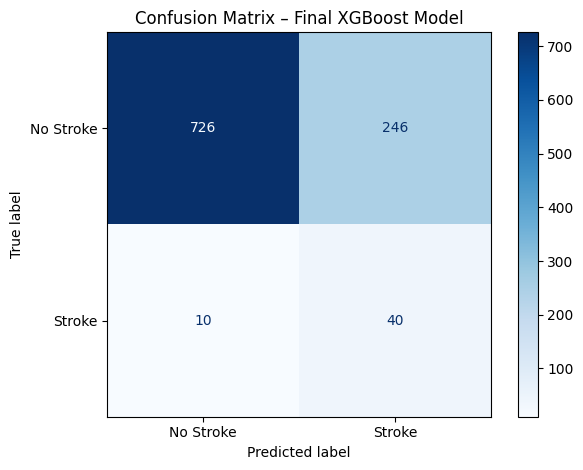

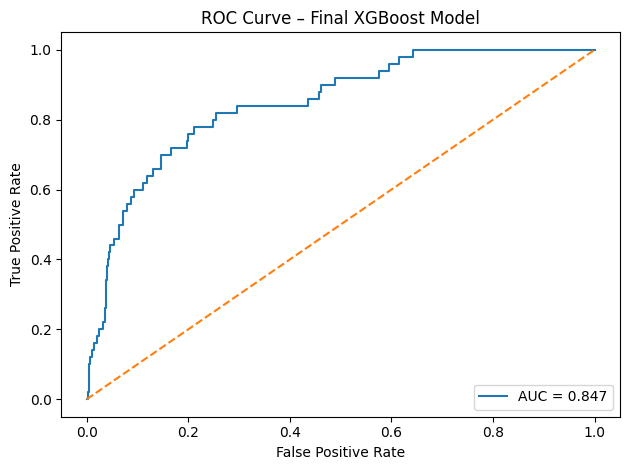

In [53]:
yTestProba = bestModel.predict(dTest)
yTestPred  = (yTestProba >= bestThreshold).astype(int)

from sklearn.metrics import average_precision_score, roc_auc_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

print("Test PR-AUC:", average_precision_score(testLabels, yTestProba))
print("Test ROC-AUC:", roc_auc_score(testLabels, yTestProba))
print("\nClassification report:")
print(classification_report(testLabels, yTestPred, digits=4))

metrics.report()

finalModelFlops = metrics.computeFinalModelFlops(
    numSamples=dTrain.num_row(),
    numBoostRounds=bestModel.best_iteration + 1,
    avgTreeDepth=bestParamsFinal["max_depth"]
)

print("\n===== FINAL MODEL ONLY =====")
print(f"Final Model FLOPs: {finalModelFlops/1e9:.3f} GFLOPs")
print(f"Final Model Share of Total GFLOPs: {(finalModelFlops / metrics.totalFlops) * 100:.2f}%")

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(testLabels, yTestPred),
    display_labels=["No Stroke", "Stroke"]
)

disp.plot(
    cmap="Blues",
    values_format="d"
)

plt.title("Confusion Matrix – Final XGBoost Model")
plt.tight_layout()
plt.savefig("XGBoostModelconfusionMatrixXgboost.png", dpi=300, bbox_inches="tight")
plt.show()

fpr, tpr, _ = roc_curve(testLabels, yTestProba)
roc_auc = roc_auc_score(testLabels, yTestProba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Final XGBoost Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("XGBoostModelrocCurveXgboost.png", dpi=300, bbox_inches="tight")
plt.show()
